<a href="https://colab.research.google.com/github/giovani-gutierrez/giovani-gutierrez.github.io/blob/main/LING111_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.4 MB/s eta 0:00:00


In [2]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import transformers as ppb
import random
import warnings
warnings.filterwarnings('ignore') # ignore warnings

In [3]:
# data
dataset = pd.read_csv('https://raw.githubusercontent.com/ucsb-ling111/final-project-riley-hull-jake-yim-giovani-gutierrez/main/Ling%20111%20Data/cleaned_data.csv?token=GHSAT0AAAAAAB57LZLGOGMLEEULMX25JQ2MZDXR5LQ')
dataset.head()

,joke_type,score,title,selftext
0,0,39,Sherlock Holmes and Dr Watson were going camping.,They pitched their tent under the stars and we...
1,0,4,"some cheesy ones, but they're some of my favor...",What's a ghost's favorite thing to get at the ...
2,0,12,What kind of horses go out after dark?,Nightmares!
3,0,28,A man in Alaska was feeling lonely...,So he decided to get a puppy. After finding a ...
4,0,13,Where did George Washington keep his armies?,In his sleevies!


In [ ]:
# grab 2000 obs due to memory
random.seed(123)
df1 = dataset.sample(n = 2000)

# concat title & selftext
df1['joke'] = dataset['title'].astype(str) + ' ' + dataset['selftext'].astype(str)

# drop unnecessary columns
df1.drop(columns = ['title', 'selftext', 'score'], inplace = True)

# preview
df1 = df1.astype({'joke': str}).reset_index(drop = True)

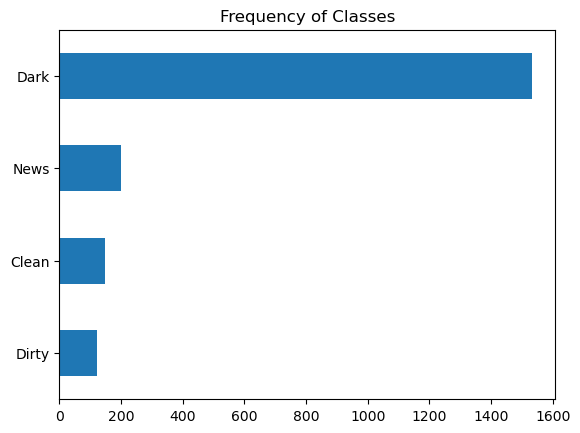

In [ ]:
df2 = df1.replace({0:'Clean', 
                   1: 'Dark', 
                   2: 'Dirty', 
                   3: 'News'})

df2['joke_type'].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
df2.head()

,joke_type,joke
0,Dark,What's the difference between my mom and cance...
1,News,BofA earnings beat tempered by concern about w...
2,Dark,"When I was little, my dad and I used to blend ..."
3,Dark,What did god say after creating his 10th nigge...
4,News,FBI Director Comey at cyber conference: ’You’r...


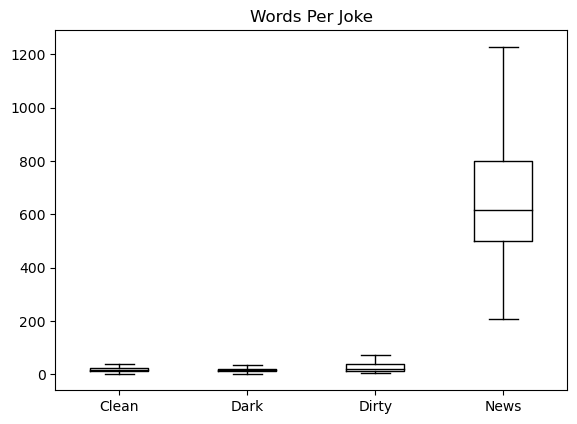

In [ ]:
df2['Words Per Joke'] = df2['joke'].str.split().apply(len)
df2.boxplot('Words Per Joke', by = 'joke_type', grid = False,
          showfliers = False, color = 'black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
# DistilBERT
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model & tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# filter out sentences that result in token lengths longer than 512
max_length = tokenizer.model_max_length
tokenized = df2['joke'].apply((lambda x: tokenizer.encode(x[:max_length], add_special_tokens=True, truncation=True))) # tokenizer

In [ ]:
# padding
max_len = 0
for sent in tokenized.values:
    if len(sent) > max_len:
        max_len = len(sent)

padded = np.array([sent + [0]*(max_len-len(sent)) for sent in tokenized.values])

In [ ]:
np.array(padded).shape

(2000, 239)

In [ ]:
# mask the padding when processing input
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 239)

In [ ]:
# Run DistilBERT
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = df2['joke_type']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 123)

train_features.shape, test_features.shape

((1500, 768), (500, 768))

In [ ]:
random.seed(123)

parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scores:  0.8446666666666667


In [ ]:
random.seed(123)

lr_clf = LogisticRegression(C = 5.263, max_iter = 3000)
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=5.263, max_iter=3000)

In [ ]:
lr_clf.score(test_features, test_labels)

0.854

In [ ]:
random.seed(123)

dummy_clf = DummyClassifier(strategy = "most_frequent")
dummy_clf.fit(train_features, train_labels)
dummy_clf.score(test_features, test_labels)

0.762

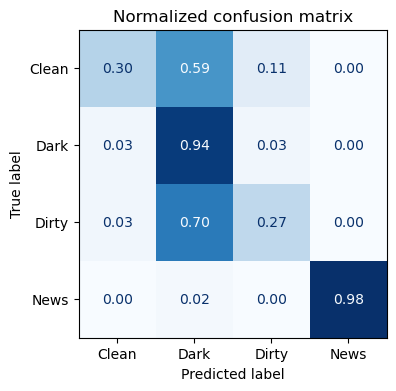

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(4, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(test_features)
plot_confusion_matrix(y_preds, test_labels, lr_clf.classes_)